# Inference for numerical data
# North Carolina births
In 2004, the state of North Carolina released a large data set containing information on births recorded in this state. This data set is useful to researchers studying the relation between habits and practices of expectant mothers and the birth of their children. We will work with a random sample of observations from this data set.

Exploratory analysis
Load the `nc` data set into our workspace.

In [1]:
import pandas as pd
nc = pd.read_csv('nc.csv')

We have observations on 13 different variables, some categorical and some numerical. The meaning of each variable is as follows.

|variable|description|
|:-------------|------------------------------------------------------------------------------------|
|`fage`|father’s age in years.|
|`mage`|mother’s age in years.|
|`mature`|maturity status of mother.|
|`weeks`|length of pregnancy in weeks.|
|`premie`|whether the birth was classified as premature (premie) or full-term.|
|`visits`|	number of hospital visits during pregnancy.|
|`marital`|whether mother is married or not married at birth.|
|`gained`|weight gained by mother during pregnancy in pounds.|
|`weight`|weight of the baby at birth in pounds.|
|`lowbirthweight`|whether baby was classified as low birthweight (low) or not (not low).|
|`gender`|gender of the baby, female or male.|
|`habit`|status of the mother as a nonsmoker or a smoker.|
|`whitemom`|whether mom is white or not white.|

**Exercise 1** What are the cases in this data set? How many cases are there in our sample?

As a first step in the analysis, we should consider summaries of the data. This can be done using the `describe` and `info` functions:

In [3]:
nc.describe()

,fage,mage,weeks,visits,gained,weight
count,829.000000,1000.000000,998.000000,991.000000,973.000000,1000.00000
mean,30.255730,27.000000,38.334669,12.104945,30.325797,7.10100
std,6.763766,6.213583,2.931553,3.954934,14.241297,1.50886
min,14.000000,13.000000,20.000000,0.000000,0.000000,1.00000
25%,25.000000,22.000000,37.000000,10.000000,20.000000,6.38000
50%,30.000000,27.000000,39.000000,12.000000,30.000000,7.31000
75%,35.000000,32.000000,40.000000,15.000000,38.000000,8.06000
max,55.000000,50.000000,45.000000,30.000000,85.000000,11.75000


In [4]:
nc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
fage              829 non-null float64
mage              1000 non-null int64
mature            1000 non-null object
weeks             998 non-null float64
premie            998 non-null object
visits            991 non-null float64
marital           999 non-null object
gained            973 non-null float64
weight            1000 non-null float64
lowbirthweight    1000 non-null object
gender            1000 non-null object
habit             999 non-null object
whitemom          998 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 101.6+ KB


As you review the variable summaries, consider which variables are categorical and which are numerical. For numerical variables, are there outliers? If you aren’t sure or want to take a closer look at the data, make a graph.

Consider the possible relationship between a mother’s smoking habit and the weight of her baby. Plotting the data is a useful first step because it helps us quickly visualize trends, identify strong associations, and develop research questions.

**Exercise 2** Make a side-by-side boxplot of `habit` and `weight`. What does the plot highlight about the relationship between these two variables?

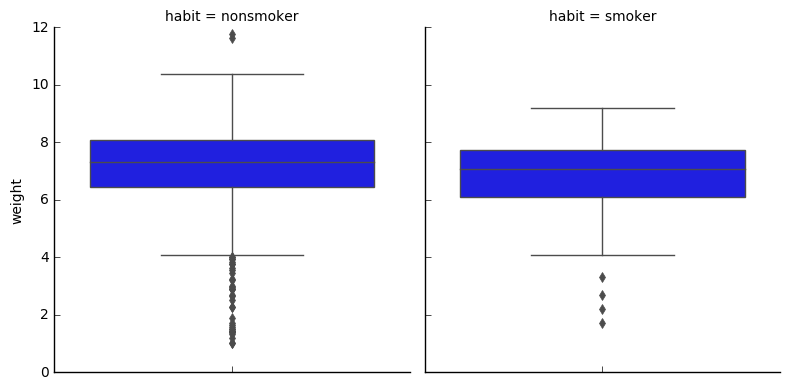

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.factorplot(y='weight', col = 'habit', kind='box', data=nc)
plt.show()

The box plots show how the medians of the two distributions compare, but we can also compare the means of the distributions using the following function to split the weight variable into the habit groups, then take the mean of each using the mean function.

In [9]:
nc.groupby('habit')['weight'].count()

habit
nonsmoker    873
smoker       126
Name: weight, dtype: int64

There is an observed difference, but is this difference statistically significant? In order to answer this question we will conduct a hypothesis test .

# Inference

**Exercise 3** Check if the conditions necessary for inference are satisfied. Note that you will need to obtain sample sizes to check the conditions. You can compute the group size using the same by command above but replacing `mean` with `count`.

**Exercise 4** Write the hypotheses for testing if the average weights of babies born to smoking and non-smoking mothers are different.

Next, we introduce a new function, `ttest_ind`, from the `statsmodels` library that we will use for conducting hypothesis tests.

In [85]:
from statsmodels.stats import weightstats as ws
import numpy as np
smoker = np.array(nc[nc['habit'] == 'smoker']['weight'])
nonsmoker = np.array(nc[nc['habit'] == 'nonsmoker']['weight'])

In [71]:
print("smoker_mean {}".format(smoker.mean()))
print("smoker_std {}".format(smoker.std()))
print("nonsmoker_mean {}".format(nonsmoker.mean()))
print("nonsmoker_std {}".format(nonsmoker.std()))
print("observed difference {}".format(nonsmoker.mean()-smoker.mean()))

smoker_mean 6.828730158730159
smoker_std 1.380668106117173
nonsmoker_mean 7.144272623138602
nonsmoker_std 1.5178105512705897
observed difference 0.315542464408443


In [81]:
test_statistic, p_value, df = ws.ttest_ind(x1=smoker, x2=nonsmoker, value=0, alternative='two-sided', usevar='unequal')
print("Test Statistic {}".format(test_statistic))
print("p value {}".format(p_value))

Test Statistic -2.359010944933508
p value 0.019450556443731927


Let’s pause for a moment to go through the arguments of this function. The first argument is `x1`, which is the sample in our test. The second argument, `x2` is the second sample. In this case our two samples are the weights of smokers and nonsmokers. The third argument, `value`, is the expected value of the difference between the mean of the two samples when the null hypothosis is true. In this case `value` is 0, since the null hypothesis sets the two population means equal to each other. The `alternative` hypothesis can be `"less"`, `"greater"`, or `"twosided"`. Lastly, the `usevar` parameter can be `"pooled"` when the standard deviations of the samples are the same and `"unequal"` when they are not.

The function below will allow us to compute a confidence interval for difference of the means of two samples assuming that:
1. Both samples have an n > 30 so that we can use the standard normal distribution.
2. The value for the null hypothesis is 0
3. We are doing a two sided test.

In [122]:
def zconfint(a, b=None, alpha=0.05, alternative="two-sided"):
    if(alternative != "two-sided"):
        raise ValueError("Currently only two-sided alternative is supported")
        
    from scipy import stats
    from scipy.stats import t
    import math
    from statsmodels.stats import weightstats as ws
    if(b is None):
        lower, higher = ws.zconfint(a, alpha=alpha, alternative=alternative)
        print ('\nThe {}% confidence interval is [{} to {}]'.format((1.0 - alpha)*100, lower, higher))
        return

    N1 = len(a)
    N2 = len(b)
    std1 = a.std(ddof=1)
    std2 = b.std(ddof=1)
    se = math.sqrt( ((std1)**2/N1) + ((std2)**2/N2)) 
    
    pvalue = 1.0 - alpha / 2
    
    diff_mean = a.mean() - b.mean()
    crit_val = stats.norm.ppf(pvalue, loc = 0, scale = 1)
    MoE = crit_val * se
    
    print('difference of the means equals', diff_mean,'\n'
      'critical value on the normal distribution is z =', crit_val, '\n'
      'margin of error =', MoE )

    print ('\nThe difference between groups is {} and the {}% confidence interval is [{} to {}]'.format(diff_mean, (1.0 - alpha)*100, diff_mean - MoE, diff_mean + MoE))

**Exercise 5** Use the function above to construct a confidence interval for the difference between the weights of babies born to smoking and non-smoking mothers.

In [123]:
zconfint(smoker, nonsmoker, alpha=0.05)

difference of the means equals -0.315542464408 
critical value on the normal distribution is z = 1.95996398454 
margin of error = 0.262165746692

The difference between groups is -0.315542464408443 and the 95.0% confidence interval is [-0.5777082111006415 to -0.053376717716244526]


# On your own
1. Calculate a 95% confidence interval for the average length of pregnancies (`weeks`) and interpret it in context. You can use the zconfint method from the weightstats library to do this. Note that `weeks` contains null values so you'll have to deal with them first. Hint: look at the pandas `dropna` function.

2. Calculate a new confidence interval for the same parameter at the 90% confidence level. 

3. Conduct a hypothesis test evaluating whether the average weight gained by younger mothers is different than the average weight gained by mature mothers.

4. Determine the age cutoff for younger and mature mothers. Use a method of your choice, and explain how your method works.

5. Pick a pair of numerical and categorical variables and come up with a research question evaluating the relationship between these variables. Formulate the question in a way that it can be answered using a hypothesis test and/or a confidence interval. Answer your question using the inference function, report the statistical results, and also provide an explanation in plain language.

Calculate a 95% confidence interval for the average length of pregnancies (weeks) and interpret it in context. You can use the zconfint method from the weightstats library to do this. Note that weeks contains null values so you'll have to deal with them first. Hint: look at the pandas dropna function.

In [124]:
zconfint(nc['weeks'].dropna(),alpha=0.05, alternative='two-sided')


The 95.0% confidence interval is [38.15279117659766 to 38.516547500757056]


 Calculate a new confidence interval for the same parameter at the 90% confidence level. 

In [125]:
zconfint(nc['weeks'].dropna(),alpha=0.1, alternative='two-sided')


The 90.0% confidence interval is [38.18203237344748 to 38.48730630390724]


Conduct a hypothesis test evaluating whether the average weight gained by younger mothers is different than the average weight gained by mature mothers.

In [87]:
younger = np.array(nc[nc['mature'] == 'younger mom']['weight'])
mature = np.array(nc[nc['mature'] == 'mature mom']['weight'])

In [93]:
print("mature_mean {}".format(mature.mean()))
print("mature_std {}".format(mature.std()))
print("younger_mean {}".format(younger.mean()))
print("younger_std {}".format(younger.std()))
print("observed difference {}".format(younger.mean()-mature.mean()))

mature_mean 7.125563909774437
mature_std 1.65283279884964
younger_mean 7.097231833910034
younger_std 1.4846205641878463
observed difference -0.02833207586440256


In [89]:
test_statistic, p_value, df = ws.ttest_ind(x1=younger, x2=mature, value=0, alternative='two-sided', usevar='unequal')
print("Test Statistic {}".format(test_statistic))
print("p value {}".format(p_value))

Test Statistic -0.18584493157735987
p value 0.8527931575628878


Determine the age cutoff for younger and mature mothers. Use a method of your choice, and explain how your method works.

In [98]:
print(nc[nc['mature'] == 'younger mom']['mage'].max())
print(nc[nc['mature'] == 'mature mom']['mage'].min())

34
35


*This notebook is based on the OpenIntro R lab [Inference for numerical data](http://htmlpreview.github.io/?https://github.com/andrewpbray/oiLabs-base-R/blob/master/inf_for_numerical_data/inf_for_numerical_data.html).*